###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes

###### Submission deadline: 7 pm, Tuesday 6 Apr 2021

**Student ID(s):**     `PLEASE ENTER YOUR ID(S) HERE`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats
from sklearn.model_selection import train_test_split

In [2]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(df_train, df_test):
    """
    Notes:
    1) preprocessing train dataset using mean
    2) do not preprocess test dataset
    ----------
    Parameters
    ---------- 
    df_train    : train df dataset
    df_test     : test df dataset
    
    Returns
    -------
    df_train    : train df dataset (after preprocessing)
    np_test     : test np array dataset (after preprocessing)
    """

    # replace 9999 with NaN
    df_train = df_train.replace([9999], np.nan)
    df_test = df_test.replace([9999], np.nan)

    '''Dealing with NaN values'''
    # remove instances which all columns are NaN
    df_train = df_train.dropna(subset = headers[1:], how = 'all')
    df_test =  df_test.dropna(subset = headers[1:], how = 'all')

    # convert df_test to np array
    np_test = np.array(df_test)

    return df_train, np_test

In [3]:
# This function should calculate prior probabilities and likelihoods from the training data and usingthem to build a naive Bayes model

def train(df_train):
    """
    Notes:
    1) calculate statistics for train dataset
    ----------
    Parameters
    ---------- 
    df_train  : train datafram dataset
    
    Returns
    -------
    pose_dict : dict with prior probability for every pose, 
                with mean and std for every xi & yi
                    eg. {pose: [pb_x, [[x1 mu, ..., y11 mu], [x1 sigma, ..., y11 sigma]]], ...}
    """

    # get all concepts(poses) as a list
    poses = list(df_train['Pose'].value_counts().index)

    # calculate statistics in training dataset
    pose_dict = dict()
    for pose in poses:
        pb_c = df_train.groupby('Pose').size()[pose] / len(df_train )   # get prior probabilities
        pose_dict[pose] = np.array([pb_c, df_train[df_train['Pose'] == pose].describe().iloc[[1,2]].values], dtype=object) # get mean & stdv for all x and y (from x1y1 to x11y11)
        

    return pose_dict

In [4]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you can re-use the training data as a test set)

def calc_phi(x, mu, sigma, smoothing=True):
    """
    Notes:
    1) get ϕ𝜎(x − mu)
    ----------
    Parameters
    ---------- 
    x       : observed x for class i
    mu      : mean for class i
    sigma   : standard deviation for class i
    
    Returns
    -------
    phi     : probability of observing value x from a variable with μ and σ
    """

    # smoothing (with epsilon 0.00000001)
    if smoothing and np.isnan(x):
        return 0.000000001

    # return the likelihood of feature x_i in class c
    phi = 1 / (sigma * np.sqrt(2 * np.pi)) * (np.e ** (- 1 / 2 * (((x - mu) / sigma) ** 2)))

    # smoothing (with epsilon 0.00000001)
    if smoothing and phi == 0:
        return 0.000000001

    return phi


def predict(np_test, pose_dict):
    """
    Notes:
    1) do not calculate phi for missing values (ignore them)
    ----------
    Parameters
    ---------- 
    np_test     : test dataset                      
                    eg. [[pose, x1, x2, ..., y10, y11], ...]
    pose_dict   : prior probability for each pose   
                    eg. {pose: [pb_x, [[x1 mu, ..., y11 mu], [x1 sigma, ..., y11 sigma]]], ...}
    
    Returns
    -------
    results     : probability of observing value x from a variable with μ and σ
    """

    results = list()
    for instance in np_test:
        # prob_dict to store all the probabilities (log form) for comparison later
        prob_dict = dict()
        features = instance[1:] # remove concept
        for pose in pose_dict:
            prob = 0
            pb_c = pose_dict[pose][0] # Prior probability of class c_j
            prob += np.log(pb_c)
            feat_len = len(features)
            for i in range(feat_len):
                x = features[i] # data of feature x/y_i for test set
                mu = pose_dict[pose][1][0][i] # mean of feature x/y_i
                sigma = pose_dict[pose][1][1][i] # std of feature x/y_i
                pb_x_c = calc_phi(x, mu, sigma)
                prob += np.log(pb_x_c)
            prob_dict[pose] = prob
        predicted = max(prob_dict, key = prob_dict.get) # choose the highest value as predicted result
        actual = instance[0]
        results.append([predicted, actual])
        
    return results

In [5]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground truth labels

def evaluate(results):
    """
    Notes:
    1) get accuracy for the results
    ----------
    Parameters
    ---------- 
    results     : 2d list       eg. [[predicted, result], ...]
    
    Returns
    -------
    accuracy  : int
    """

    t = 0   # true positive
    n = len(results)
    for predicted, actual in results:
        if predicted == actual:
            t += 1

    accuracy = t / n

    return accuracy

In [6]:
# Naive Bayes answer

train_path = 'data/train.csv'
test_path = 'data/test.csv'
headers = ['Pose', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11']
df_train = pd.read_csv(train_path, names=headers)
df_test = pd.read_csv(test_path, names=headers)
df_train, np_test = preprocess(df_train, df_test)
pose_dict = train(df_train)
results = predict(np_test, pose_dict)
accuracy = evaluate(results)

print('Naive Bayes with Gaussian accuracy:', accuracy)

Naive Bayes with Gaussian accuracy: 0.75


## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [7]:
def get_con_matrix(results, poses):
    """
    Notes:
    1) convert result list to confusion matrix
    ----------
    Parameters
    ---------- 
    results     : 2d list       eg. [[predicted, result], ...]
    poses       : pose list     eg. [pose, ...]

    Returns
    -------
    con_matrix  : confusion matrix for the result
    """

    # create a dict for indexing
    d = {key: 0 for key in list(pose_dict.keys())}
    i = 0
    for key in d.keys():
        d[key] += i
        i += 1

    # create confution matrix
    length = len(pose_dict)
    con_matrix = np.zeros(shape=[length, length], dtype='int64')
    for predicted, actual in results:
        i = d[actual]
        j = d[predicted]
        con_matrix[i][j] += 1

    return con_matrix

In [8]:
def print_model_eval(con_matrix):
    """
    ----------
    Parameters
    ---------- 
    con_matrix  : oonfusion matrix of the results

    Returns
    -------
    print Precision, Recall, F-score for Macro & Micro averaging
    """

    num_rows, num_cols = con_matrix.shape

    TPs = con_matrix.diagonal()         # TP
    sum_rows = con_matrix.sum(axis=1)   # TP + FP
    sum_cols = con_matrix.sum(axis=0)   # TP + FN

    mac_ave_pre = sum(TPs / sum_cols) / num_cols
    mac_ave_rec = sum(TPs / sum_rows) / num_rows
    mac_f = 2 * mac_ave_pre * mac_ave_rec / (mac_ave_pre + mac_ave_rec)

    mic_ave_pre = sum(TPs) / sum(sum_cols)
    mic_ave_rec = sum(TPs) / sum(sum_rows)
    mic_f = 2 * mic_ave_pre * mic_ave_rec / (mic_ave_pre + mic_ave_rec)

    print("Precision with Macro-averaging   :", mac_ave_pre)
    print("Recall with Macro-averaging      :", mac_ave_rec)
    print("F1-score with Macro-averaging    :", mac_f)
    print("Precision with Micro-averaging   :", mic_ave_pre)
    print("Recall with Micro-averaging      :", mic_ave_rec)
    print("F1-score with Micro-averaging    :", mic_f)


In [9]:
# Question 1 answer
poses = list(pose_dict.keys())
print(poses) # show at which index is which pose
print()
con_matrix = get_con_matrix(results, poses)
print(con_matrix)
print()
print_model_eval(con_matrix)

['mountain', 'downwarddog', 'bridge', 'tree', 'childs', 'trianglepose', 'plank', 'warrior2', 'warrior1', 'seatedforwardbend']

[[26  0  0  4  0  0  0  0  0  0]
 [ 0 13  1  0  1  0  0  0  0  0]
 [ 0  5  6  0  2  0  1  0  0  0]
 [ 0  0  1  3  0  0  0  0  2  0]
 [ 0  0  0  0 11  0  0  0  0  1]
 [ 0  0  0  0  0  4  0  0  0  0]
 [ 0  0  2  0  0  1  6  0  0  0]
 [ 0  0  0  1  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  1  0  4  0]
 [ 0  1  0  0  3  1  0  0  0  4]]

Precision with Macro-averaging   : 0.7189602683178535
Recall with Macro-averaging      : 0.736468253968254
F1-score with Macro-averaging    : 0.7276089555382642
Precision with Micro-averaging   : 0.75
Recall with Micro-averaging      : 0.75
F1-score with Micro-averaging    : 0.75


### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

In [10]:
def plot_qq(df, pose, remove=True):
    """
    Notes:
    1) plot QQ-plot for each feature for pose input
    ----------
    Parameters
    ---------- 
    df_train    : train dataframe dataset
    pose        : pose list
    remove      : remove missing values? 
    """

    fig = plt.figure(figsize=(25,5))
    gs = fig.add_gridspec(2, 11, hspace=0, wspace=0)
    ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11), (ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22)) = gs.subplots(sharex='col', sharey='row')
    fig.suptitle(str(pose) + ' QQ-plot')

    i = 0
    subplots = ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11), (ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22))
    features = headers[1:]
    for axis_plot in subplots:
        for plot in axis_plot:
            x = np.array(df[df['Pose'] == pose][features[i]])
            if remove: # remove missing values
                x = x[x != 9999]
            mu = x.mean()
            stdv = x.std()
            z = (x - mu) / stdv
            z = np.sort(z)
            tq = list()
            for j in np.linspace(0, 1, len(x)):
                tq.append(scipy.stats.norm.ppf(j))
            plot.scatter(tq, z, s=5)
            i += 1

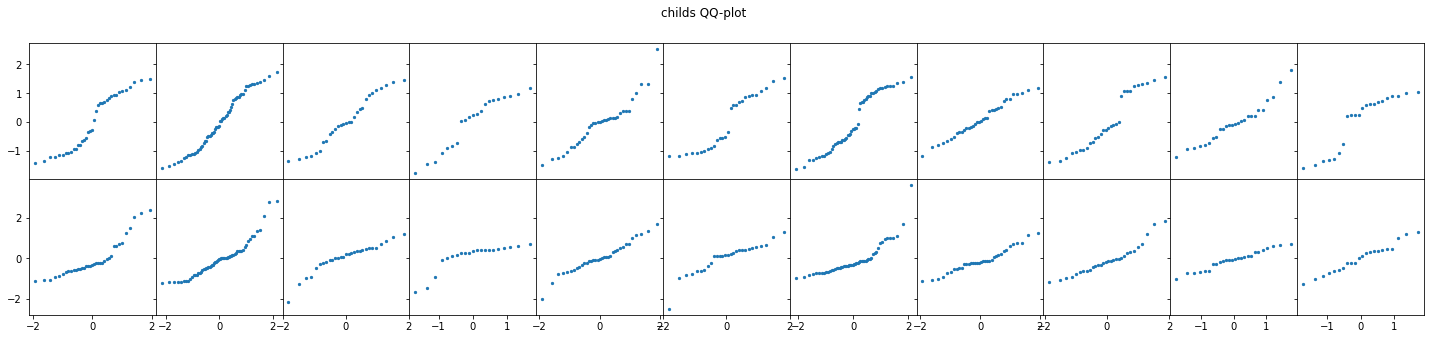

In [11]:
# Question 2 answer
# Plot QQ plot for given class

all_path = 'data/all.csv'   # combine train.csv & test.csv
headers = ['Pose', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11']
df_all = pd.read_csv(all_path, names=headers)   # convert to dataframe
pose = 'childs' # choose one class
plot_qq(df_all, pose, remove=True)

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [12]:
def predict_kde(np_test, df_train, SIGMA=5):
    """
    Notes:
    1) do not calculate phi for missing values (ignore them)
    ----------
    Parameters
    ---------- 
    np_test     : 2d list       
                    eg. [[predicted, result], ...]
    df_train    : train dataframe dataset
    SIGMA       : kernel bandwidth (default 5)

    Returns
    -------
    results     : 2d list       
                    eg. [[predicted, result], ...]
    """


    # get all concepts(poses) as a list
    poses = list(df_train['Pose'].value_counts().index)

    # calculate prior prob and convert train data into np array for each pose
    d = dict()
    for pose in poses:
        pb_c = df_train.groupby('Pose').size()[pose] / len(df_train)
        d[pose] = np.array([pb_c, df_train[df_train['Pose'] == pose].iloc[:,1:].to_numpy()], dtype=object)

    results = list()
    for instance in np_test:
        # prob_dict to store all the probabilities (log form) for comparison later
        prob_dict = dict()
        features = instance[1:] # remove concept
        for pose in poses:
            prob_sum = 0
            pb_c = d[pose][0] # get prior probability for pose j
            prob_sum += np.log(pb_c)
            pose_dp = d[pose][1] # get all train data point for pose j
            feat_len = len(features)
            for i in range(feat_len):
                dpn_array = pose_dp[:,i] # get all rows of pose i in train set
                dpn_array = dpn_array[~np.isnan(dpn_array)] # avoid missing values in train set
                dp_test = features[i]    # datapoint of pose i in test set
                phi = 0
                for dpi in dpn_array:
                    phi += calc_phi(dp_test, dpi, SIGMA)
                phi = phi / len(dpn_array)
                prob_sum += np.log(phi)

            prob_dict[pose] = prob_sum

        predicted = max(prob_dict, key = prob_dict.get) # choose the highest value as predicted result
        actual = instance[0]
        results.append([predicted, actual])
    return results

In [16]:
# Question 3 answer
# Predict KDE with sigma = 0.1 & 5

train_path = 'data/train.csv'
test_path = 'data/test.csv'
headers = ['Pose', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11']
df_train = pd.read_csv(train_path, names=headers)
df_test = pd.read_csv(test_path, names=headers)
df_train, np_test = preprocess(df_train, df_test)

results_kde = predict_kde(np_test, df_train, SIGMA=5)
accuracy = evaluate(results_kde)

poses = list(pose_dict.keys())
print(poses) # show at which index is which pose
print()

for i in (0.1, 5):
    results_kde = predict_kde(np_test, df_train, SIGMA=i)
    accuracy = evaluate(results_kde)
    con_matrix = get_con_matrix(results, poses)
    print(con_matrix)
    print('==> Naive Bayes with KDE sigma =', i, 'accuracy:', accuracy)
    print()

['mountain', 'downwarddog', 'bridge', 'tree', 'childs', 'trianglepose', 'plank', 'warrior2', 'warrior1', 'seatedforwardbend']

[[26  0  0  4  0  0  0  0  0  0]
 [ 0 13  1  0  1  0  0  0  0  0]
 [ 0  5  6  0  2  0  1  0  0  0]
 [ 0  0  1  3  0  0  0  0  2  0]
 [ 0  0  0  0 11  0  0  0  0  1]
 [ 0  0  0  0  0  4  0  0  0  0]
 [ 0  0  2  0  0  1  6  0  0  0]
 [ 0  0  0  1  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  1  0  4  0]
 [ 0  1  0  0  3  1  0  0  0  4]]
==> Naive Bayes with KDE sigma = 0.1 accuracy: 0.6071428571428571

[[26  0  0  4  0  0  0  0  0  0]
 [ 0 13  1  0  1  0  0  0  0  0]
 [ 0  5  6  0  2  0  1  0  0  0]
 [ 0  0  1  3  0  0  0  0  2  0]
 [ 0  0  0  0 11  0  0  0  0  1]
 [ 0  0  0  0  0  4  0  0  0  0]
 [ 0  0  2  0  0  1  6  0  0  0]
 [ 0  0  0  1  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  1  0  4  0]
 [ 0  1  0  0  3  1  0  0  0  4]]
==> Naive Bayes with KDE sigma = 5 accuracy: 0.7946428571428571



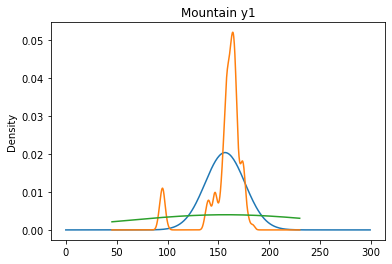

In [125]:
# Plot probability density graph for Gaussian, KDE (sigma=0.1 & 0.5)

mean = df_train[df_train['Pose'] == 'mountain']['y1'].describe()[1]
stdv = df_train[df_train['Pose'] == 'mountain']['y1'].describe()[2]
x = np.arange(0, 300, 1)
y = scipy.stats.norm.pdf(x, mean, stdv)
plt.plot(x, y)
x = df_train[df_train['Pose'] == 'mountain']['y1']
x.plot.kde(bw_method=0.1)
x.plot.kde(bw_method=5)
plt.title('Mountain y1')
plt.show()

### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

In [33]:
def predict_kde_rs(df, num=5):
    """
    Notes:
    1) print average accuracy for the results
    ----------
    Parameters
    ---------- 
    df  : dataset 
    num : num of epoch
    """

    y = np.array(df['Pose'])
    X = np.array(df.drop(columns = ['Pose']))

    sigma_result = dict()
    for sigma in range(5,26):
        accuracy = []
        print('|Sigma', sigma, '|')
        for i in range (0,num):
            X_train,X_test,y_train,y_test = train_test_split(X, y, test_size= 0.5, random_state=i)

            # reshape so it can be converted to df
            y_train = y_train.reshape(len(y_train), 1)
            np_train = np.append(y_train, X_train, axis=1)
            y_test = y_test.reshape(len(y_test), 1)
            np_test =  np.append(y_test, X_test, axis=1)

            # convert to df_train and np_test
            df_train = pd.DataFrame(np_train, columns=headers)
            df_test = pd.DataFrame(np_test, columns=headers)
            df_train, np_test = preprocess(df_train, df_test)

            # predict
            results_kde = predict_kde(np_test,df_train, sigma)
            accuracy.append(evaluate(results_kde))
            print('result', i+1, ':', round(evaluate(results_kde), 3))

        sigma_result[sigma] = np.array(accuracy).mean()
        print('average:', round(np.array(accuracy).mean(), 3))
        print('==========')

    return

In [34]:
# Random hold-out to choose the best kernel bandwidth

headers = ['Pose', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11']
df = pd.read_csv('data/all.csv', names=headers) # data.csv combined train & test data
predict_kde_rs(df, num=5)

|Sigma 5 |
result 1 : 0.834
result 2 : 0.783
result 3 : 0.779
result 4 : 0.775
result 5 : 0.775
average: 0.789
|Sigma 6 |
result 1 : 0.827
result 2 : 0.788
result 3 : 0.779
result 4 : 0.78
result 5 : 0.777
average: 0.79
|Sigma 7 |
result 1 : 0.836
result 2 : 0.797
result 3 : 0.786
result 4 : 0.792
result 5 : 0.772
average: 0.797
|Sigma 8 |
result 1 : 0.841
result 2 : 0.795
result 3 : 0.789
result 4 : 0.787
result 5 : 0.772
average: 0.797
|Sigma 9 |
result 1 : 0.841
result 2 : 0.802
result 3 : 0.786
result 4 : 0.787
result 5 : 0.777
average: 0.799
|Sigma 10 |
result 1 : 0.841
result 2 : 0.807
result 3 : 0.789
result 4 : 0.79
result 5 : 0.77
average: 0.799
|Sigma 11 |
result 1 : 0.836
result 2 : 0.807
result 3 : 0.784
result 4 : 0.79
result 5 : 0.782
average: 0.8
|Sigma 12 |
result 1 : 0.841
result 2 : 0.802
result 3 : 0.784
result 4 : 0.79
result 5 : 0.784
average: 0.8
|Sigma 13 |
result 1 : 0.839
result 2 : 0.8
result 3 : 0.786
result 4 : 0.794
result 5 : 0.777
average: 0.799
|Sigma 14

### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.